Test of the RedPitaya with QCodes drivers

In [1]:
import os
import time
import numpy as np

import qcodes as qc
from qcodes import validators as vals
from qcodes.instrument import ( Instrument,
                                InstrumentChannel,
                                InstrumentModule,
                                ManualParameter,
                                MultiParameter,
                                VisaInstrument,
                                )

from qcodes.instrument.parameter import ParameterWithSetpoints, Parameter

<h4>Setpoints</h4>

In [2]:
class GeneratedSetPoints(Parameter):
    # A parameter that generates a setpoint array from start, stop and num points parameters.

    def __init__(self, start_param, stop_param, num_points_param, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._startparam = start_param
        self._stopparam = stop_param 
        self._numpointsparam = num_points_param

    def get_raw(self):
        return np.linspace(self._start_param(), self._stop_param() -1, self._num_points_param())

<h4>Redpitaya driver</h4>

In [3]:
class Redpitaya(VisaInstrument):
    def __init__(self, name, address, **kwargs):
        super().__init__(name, address, terminator='\r\n', **kwargs)
        
        # Connect to the Redpitaya board using the appropriate communication protocol
        self._address = address
        # Connect using TCP or USB
        # For wireless connection use TCPIP::address::port::SOCKET
        # For USB connection use ***
        
        # see https://redpitaya.readthedocs.io/en/latest/appsFeatures/remoteControl/remoteControl.html
        # for more detail of the commands and of their limits
        
        
        # analog outs
        input_pin = [ 'AIN0', 'AIN1', 'AIN2', 'AIN3' ]
        output_pin = [ 'AOUT0', 'AOUT1', 'AOUT2', 'AOUT3' ]
        max_get_voltage = 3.3
        max_set_voltage = 1.8
        
        for pin in (input_pin + output_pin):
            # get the voltage for any of the analog pins
            self.add_parameter( name='get_'+pin,
                                label='Read input/output voltage on pin',
                                vals=vals.Numbers(-max_get_voltage, max_get_voltage),
                                unit='V',
                                set_cmd=None,
                                get_cmd='ANALOG:PIN? ' + pin,
                                get_parser=float
                                )        
            
        for pin in output_pin:
            # set the voltage for the output pins
            self.add_parameter( name='set_'+pin,
                                label='Set output voltage on pin',
                                vals=vals.Numbers(-max_set_voltage, max_set_voltage),
                                unit='V',
                                set_cmd='ANALOG:PIN ' + pin + ',' + '{:.12f}',
                                get_cmd=None,
                                )  
            
        # digital outputs
        # In progress...
            
            

        ## signal generators
        min_frequency = 1
        max_frequency = 50e6
        max_voltage = 1
        awg_array_size = 16384
        
        
        # output generators
        outputs = ['1', '2']
        for out in outputs:
            self.add_parameter( name='OUT' + out + '_status',
                                label='Status of the generator 1',
                                vals=vals.Enum('ON', 'OFF'),
                                set_cmd='OUTPUT' + out + ':STATE ' + '{}',
                                get_cmd='OUTPUT' + out + ':STATE?'
                                )

            self.add_parameter( name='OUT' + out + '_function',
                                label='Output function of the generator',
                                vals=vals.Enum('SINE', 'SQUARE', 'TRIANGLE', 'SAWU', 'SAWD', 'PWM', 'ARBITRARY', 'DC', 'DC_NEG'),
                                set_cmd='SOUR' + out + ':FUNC ' + '{}',
                                get_cmd='SOUR' + out + ':FUNC?'
                                )        

            self.add_parameter( name='OUT' + out + '_frequency',
                                label='Frequency of the generator',
                                vals=vals.Numbers(min_frequency, max_frequency),
                                unit='Hz',
                                set_cmd='SOUR' + out + ':FREQ:FIX ' + '{:.12f}',
                                get_cmd='SOUR' + out + ':FREQ:FIX?',
                                get_parser=float
                                )

            self.add_parameter( name='OUT' + out + '_phase',
                                label='Phase of the generator',
                                vals=vals.Numbers(-360, 360),
                                unit='deg',
                                set_cmd='SOUR' + out + ':PHAS  ' + '{:.12f}',
                                get_cmd='SOUR' + out + ':PHAS?',
                                get_parser=float
                                )

            self.add_parameter( name='OUT' + out + '_amplitude',
                                label='Amplitude of the generator',
                                vals=vals.Numbers(-max_voltage, max_voltage),
                                unit='V',
                                set_cmd='SOUR' + out + ':VOLT ' + '{:.12f}',
                                get_cmd='SOUR' + out + ':VOLT?',
                                get_parser=float
                                )     

            self.add_parameter( name='OUT' + out + '_offset',
                                label='Amplitude offset of the generator',
                                vals=vals.Numbers(-max_voltage, max_voltage),
                                unit='V',
                                set_cmd='SOUR' + out + ':VOLT:OFFS ' + '{:.12f}',
                                get_cmd='SOUR' + out + ':VOLT:OFFS?',
                                get_parser=float
                                )  

            self.add_parameter( name='OUT' + out + '_duty_cycle',
                                label='Duty cycle of the generator',
                                vals=vals.Numbers(0, 1),
                                unit='',
                                set_cmd='SOUR' + out + ':DCYC ' + '{:.12f}',
                                get_cmd='SOUR' + out + ':DCYC?',
                                get_parser=float
                                )  

            self.add_parameter( name='OUT' + out + '_awg',
                                label='Arbitrary waveform for the output',
                                vals=vals.Arrays(min_value=-max_voltage, max_value=max_voltage ,shape=(awg_array_size,)),
                                unit='',
                                set_cmd='SOUR' + out + ':TRAC:DATA:DATA ' + '{:.12f}',
                                get_cmd='SOUR' + out + ':TRAC:DATA:DATA?',
                                get_parser=str
                                ) 

            self.add_parameter( name='OUT' + out + '_type',
                                label='Set output to pulsed or continuous',
                                vals=vals.Enum('BURST', 'CONTINUOUS'),
                                set_cmd='SOUR' + out + ':BURS:STAT ' + '{}',
                                get_cmd='SOUR' + out + ':BURS:STAT?'
                                )

            self.add_parameter( name='OUT' + out + '_pulse_cycle',
                                label='Set the number of periods in a pulse',
                                vals=vals.Numbers(1, 50000),
                                unit='',
                                set_cmd='SOUR' + out + ':DCYC ' + '{:.12f}',
                                get_cmd='SOUR' + out + ':DCYC?',
                                get_parser=float
                                )         

            self.add_parameter( name='OUT' + out + '_pulse_repetition',
                                label='Set the number of repeated pulses (65536 = inf)',
                                vals=vals.Numbers(1, 65536),
                                unit='',
                                set_cmd='SOUR' + out + ':BURS:NOR ' + '{:.12f}',
                                get_cmd='SOUR' + out + ':BURS:NOR?',
                                get_parser=float
                                ) 

            self.add_parameter( name='OUT' + out + '_pulse_period',
                                label='Set the duration of a single pulse in microseconds',
                                vals=vals.Numbers(1, 500e6),
                                unit='',
                                set_cmd='SOUR' + out + ':BURS:INT:PER ' + '{:.12f}',
                                get_cmd='SOUR' + out + ':BURS:INT:PER?',
                                get_parser=float
                                ) 

            self.add_parameter( name='OUT' + out + '_trigger_source',
                                label='Set the trigger source for the output',
                                vals=vals.Enum('EXT_PE', 'EXT_NE', 'INT', 'GATED'),
                                set_cmd='SOUR' + out + ':TRIG:SOUR ' + '{}',
                                get_cmd='SOUR' + out + ':TRIG:SOUR?'
                                )

        
        
        ## acquisition
        self.add_parameter( name='ADC_decimation',
                            label='Set the decimation factor, each sample is the average of skipped samples if decimation > 1',
                            vals=vals.Enum(1,2,4,8,16,32,64,128,256,512,1024,2048,4096,8192,16384,32768,65536),
                            unit='',
                            set_cmd='ACQ:DEC ' + '{}',
                            get_cmd='ACQ:DEC?',
                            get_parser=int
                            )
        
        self.add_parameter( name='ADC_averaging',
                            label='Enable/disable averaging',
                            vals=vals.Enum('ON', 'OFF'),
                            set_cmd='ACQ:AVG ' + '{}',
                            get_cmd='ACQ:AVG?'
                            )
        
        
        # trigger
        self.add_parameter( name='ADC_trigger',
                            label='Disable triggering, trigger immediately or set trigger source and edge',
                            vals=vals.Enum('DISABLED', 'NOW', 'CH1_PE', 'CH1_NE', 'CH2_PE', 'CH2_NE', 'EXT_PE', 'EXT_NE', 'AWG_PE', 'AWG_NE'),
                            set_cmd='ACQ:TRIG ' + '{}',
                            get_cmd='ACQ:TRIG:STAT?'
                            )
        
        self.add_parameter( name='ADC_trigger_delay',
                            label='Trigger delay (in units of samples)',
                            vals=vals.Numbers(0, np.inf),
                            set_cmd='ACQ:TRIG:DLY ' + '{}',
                            get_cmd='ACQ:TRIG:DLY?'
                            )
        
        self.add_parameter( name='ADC_trigger_delay_ns',
                            label='Trigger delay (in nanoseconds)',
                            vals=vals.Numbers(0, np.inf),
                            unit='ns',
                            set_cmd='ACQ:TRIG:DLY:NS ' + '{:.12f}',
                            get_cmd='ACQ:TRIG:DLY:NS?',
                            get_parser=float 
                            )        
        
        self.add_parameter( name='ADC_trigger_level',
                            label='The trigger level in volts',
                            vals=vals.Numbers(-np.inf, np.inf),
                            unit='V',
                            set_cmd='ACQ:TRIG:LEV ' + '{:.12f}',
                            get_cmd='ACQ:TRIG:LEV?',
                            get_parser=float 
                            )       

        
        # data pointers
        self.add_parameter( name='ADC_trigger_pointer',
                            label='Returns the position where the trigger event happened',
                            set_cmd=None,
                            get_cmd='ACQ:TPOS?'
                            )
        
        self.add_parameter( name='ADC_write_pointer',
                            label='Returns the current position of the write pointer',
                            set_cmd=None,
                            get_cmd='ACQ:WPOS?'
                            )
    
    
    
        ## inputs parameters
        # data
        buffer_size = 2**14
        
        self.add_parameter( name='ADC_data_units',
                            label='Select units in which the acquired data will be returned',
                            vals=vals.Enum('RAW', 'VOLTS'),
                            set_cmd='ACQ:DATA:UNITS ' + '{}',
                            get_cmd='ACQ:DATA:UNITS?'
                            )
        
        self.add_parameter( name='ADC_data_format',
                            label='Select formats in which the acquired data will be returned',
                            vals=vals.Enum('BIN', 'ASCII'),
                            set_cmd='ACQ:DATA:FORMAT ' + '{}',
                            get_cmd=None
                            )
        
        self.add_parameter( name='ADC_buffer_size',
                            label='Returns the buffer size',
                            get_cmd='ACQ:BUF:SIZE?'
                            )
        
        
        
        inputs = ['1', '2']
        for inp in inputs:
            self.add_parameter( name='IN' + inp + '_gain',
                                label='Set the gain to HIGH or LOW, which refers to jumper settings on the fast analog inputs',
                                vals=vals.Enum('HV', 'LV'),
                                set_cmd='ACQ:SOUR' + inp + ':GAIN ' + '{}',
                                get_cmd='ACQ:SOUR' + inp + ':GAIN?'
                                )
            
            self.add_parameter( name='IN' + inp + '_read_buffer',
                                label='Read the full buffer',
                                get_cmd='ACQ:SOUR' + inp + ':DATA?'
                                )
        
        
        # good idea to call connect_message at the end of your constructor.
        # this calls the 'IDN' parameter that the base Instrument class creates 
        # for every instrument  which serves two purposes:
        # 1) verifies that you are connected to the instrument
        # 2) gets the ID info so it will be included with metadata snapshots later.
        self.connect_message() 
        
        
        
    def reset(self):
        # Reset both the outputs
        self.write('GEN:RST')
        
        
    def ADC_start(self):
        # Start the acquisition
        self.write('ACQ:START')
        
    def ADC_stop(self):
        # Stop the acquisition
        self.write('ACQ:RST')
        
    def ADC_reset(self):
        # Stops the acquisition and sets all parameters to default values
        self.write('ACQ:START')
        
        

    def align_channels_phase(self):
        # Align the phase of the outputs
        self.write('PHAS:ALIGN')

    def trigger_channels(self):
        # Triggers immediately both the channels
        self.write('SOUR:TRIG:INT')

    def CH1_trigger(self):
        # Triggers immediately channel 1
        self.write('SOUR1:TRIG:INT')

    def CH2_trigger(self):
        # Triggers immediately channel 2
        self.write('SOUR2:TRIG:INT')
        
        
        
        
        
    def format_output_status(self, status_in):
        # to return ON and OFF when asked for the status of outputs
        if status_in == '0': 
            status_out = 'OFF'
        elif status_in == '1': 
            status_out = 'ON'
        
        return status_out
    
        

<h4>Test of the drivers</h4>

In [4]:
red = Redpitaya('redpitaya', address='TCPIP::192.168.1.30::5000::SOCKET')

Connected to: REDPITAYA INSTR2020 (serial:0, firmware:01-02) in 0.30s


In [23]:
red.OUT1_amplitude(0.2)
red.OUT1_frequency(1e6)
red.OUT1_status('ON')

red.OUT2_amplitude(0.1)
red.OUT2_frequency(2e6)
red.OUT2_status('ON')

In [24]:
red.trigger_channels()

red.ADC_start()
time.sleep(0.1)
red.ADC_stop()

In [25]:
data_string_1 = np.array( red.IN1_read_buffer()[1:-1].split(',') )
data_1 = data_string_1.astype(float)

data_string_2 = np.array( red.IN2_read_buffer()[1:-1].split(',') )
data_2 = data_string_2.astype(float)

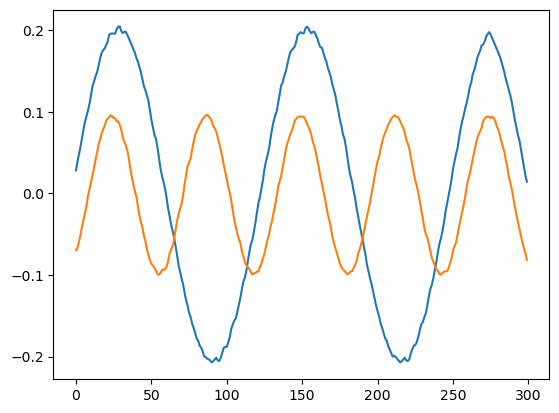

In [26]:
import matplotlib.pyplot as plt
plt.plot( data_1[0:300] )
plt.plot( data_2[0:300] )

In [9]:
class Oscilloscope():
    
    
    FS = 125000000.0             # sampling frequency
    DW = 16                      # register width - linear addition multiplication
    _DWr  = (1 << (DW-1)) - 1    # fixed point range
    
    # buffer parameters
    buffer_size = 2**14          # buffer size
    CW = 31                      # counter size
    _CWr = 2**CW                 # twice the counter size

    ranges = (1.0, 20.0)          # analog stage range voltages
    

    def data(self, size: int = buffer_size, ptr: int = None) -> np.array:
        """Data.
        Parameters
        ----------
        siz : int, optional
            Number of data samples to be read from the FPGA buffer.
        ptr : int, optional
            End of data pointer, only use if you understand
            the source code.
        Returns
        -------
        array
            Array containing float samples scaled
            to the selected analog range.
            The data is alligned at the end to the last sample
            stored into the buffer.
        """
        if ptr is None:
            ptr = int(self.pointer)
            
        adr = (self.buffer_size + ptr - size) % self.buffer_size
        scale = self.__input_range / float(self._DWr)
        
        # TODO: avoid making copy of entire array
        wave = np.roll(self.buffer, -ptr)
        
        return (wave.astype('float32')[-size:] * scale)
    